In [141]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [142]:
#import the orders_products_combined
df_merged = pd.read_pickle(r'C:\Users\Sthif\01-2025-Instacart Basket Analysis\02 Data\Prepared Data\instacart_data.pkl')
path = r'C:\Users\Sthif\01-2025-Instacart Basket Analysis'
df_merged = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'instacart_data.pkl'))

### Step 2:

In [143]:
# 2. Address Security Implications (PII Data)
# Replace with 'Unknown'
df_merged['first_name'] = 'Unknown'
df_merged['last_name'] = 'Unknown'
df_merged['user_id'] = 'Unknown'

print(df_merged[['first_name', 'last_name', 'user_id']].head())

  first_name last_name  user_id
0    Unknown   Unknown  Unknown
1    Unknown   Unknown  Unknown
2    Unknown   Unknown  Unknown
3    Unknown   Unknown  Unknown
4    Unknown   Unknown  Unknown


### Step 3:

In [144]:
# Create a 'Region' column
df_merged.loc[df_merged['state'].isin(['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut',
                                       'New York', 'New Jersey', 'Pennsylvania']), 'Region'] = 'Northeast'

df_merged.loc[df_merged['state'].isin(['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'Missouri', 'Minnesota',
                                       'Iowa', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas']), 'Region'] = 'Midwest'

df_merged.loc[df_merged['state'].isin(['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky', 'Tennessee',
                                       'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Alabama', 'Mississippi',
                                       'Arkansas', 'Louisiana', 'Oklahoma', 'Texas']), 'Region'] = 'South'

df_merged.loc[df_merged['state'].isin(['Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah',
                                       'Nevada', 'Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']), 'Region'] = 'West'

df_merged.loc[~df_merged['state'].isin(['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut',
                                        'New York', 'New Jersey', 'Pennsylvania', 'Ohio', 'Michigan', 'Indiana', 'Wisconsin',
                                        'Illinois', 'Missouri', 'Minnesota', 'Iowa', 'North Dakota', 'South Dakota',
                                        'Nebraska', 'Kansas', 'Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky',
                                        'Tennessee', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Alabama',
                                        'Mississippi', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas', 'Montana', 'Idaho',
                                        'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 'Nevada', 'Washington',
                                        'Oregon', 'California', 'Alaska', 'Hawaii']), 'Region'] = 'Other'

print(df_merged['Region'].value_counts())

Region
South        9526134
West         7765088
Midwest      7107586
Northeast    5356272
Other         573683
Name: count, dtype: int64


In [145]:
# Add a spending flag: High Spender vs Low Spender
df_merged['spending_flag'] = df_merged['prices'].apply(lambda x: 'High Spender' if x > 10 else 'Low Spender')

In [146]:
# Group data by Region and Spending Flag
region_spending = pd.crosstab(df_merged['Region'], df_merged['spending_flag'], normalize='index') * 100


print(region_spending)

spending_flag  High Spender  Low Spender
Region                                  
Midwest           32.478650    67.521350
Northeast         32.377221    67.622779
Other             32.272875    67.727125
South             32.523813    67.476187
West              32.445157    67.554843


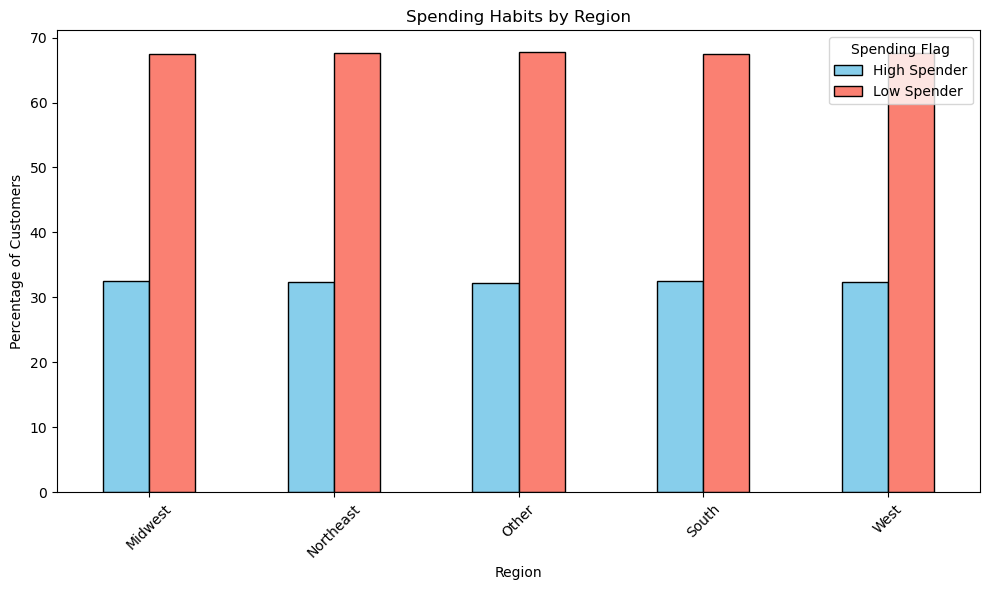

In [147]:
# Crosstab for spending habits by region
region_spending_sample = pd.crosstab(sample_df['Region'], sample_df['spending_flag'], normalize='index') * 100

# Plot the spending habits by region
bar = region_spending.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Spending Habits by Region')
plt.xlabel('Region')
plt.ylabel('Percentage of Customers')
plt.legend(title='Spending Flag')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [148]:
# Save the chart as a PNG file
bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'spending_habits_region.png'))

### Step 4:

In [164]:
# Create an exclusion flag for low-activity customers
df_merged['low_activity_flag'] = df_merged['order_number'] < 5
df_high_activity = df_merged[df_merged['low_activity_flag'] == False]

In [165]:
# Verify the subset
print(f"Subset shape: {df_high_activity.shape}")  
print(df_high_activity.head()) 

Subset shape: (24414877, 31)
    order_id  user_id  order_number  orders_day_of_week  order_hour_of_day  \
16    431534  Unknown             5                   4                 15   
17    431534  Unknown             5                   4                 15   
18    431534  Unknown             5                   4                 15   
19    431534  Unknown             5                   4                 15   
20    431534  Unknown             5                   4                 15   

    days_since_prior_order  product_id  add_to_cart_order  reordered  \
16                    28.0         196                  1          1   
17                    28.0       12427                  2          1   
18                    28.0       10258                  3          1   
19                    28.0       25133                  4          1   
20                    28.0       10326                  5          0   

             product_name  ...  last_name  gender    state age date_j

In [187]:
print(df_high_activity.shape)
print(df_high_activity['order_number'].min())  

(24414877, 32)
5


In [167]:
# Saving the subset
df_high_activity.to_csv(os.path.join(path, '02 Data','Prepared Data', 'high_activity_customers.csv'))

### Step 5:

##### Define profiles:
###### Using variables such as age, income, department_id, num_dependents, and purchase times (orders_day_of_week, order_hour_of_day) 
###### - Young Shopper: Customers under 30, regardless of dependents.
###### - Middle-Aged Shopper: Younger, Customers aged 30–60 with dependents.
###### - Senior Shopper: Customers aged over 60, regardless of dependents.
###### - Budget Shopper: Lower income, prefers low-cost items.

In [168]:
# Create a profiling function
def customer_profile(row):
    if row['age'] < 30:  # All customers under 30
        return 'Young Shopper'
    elif 30 <= row['age'] <= 60 and row['num_dependants'] > 0:  # Middle-aged with dependents
        return 'Middle-Aged Shopper'
    elif row['age'] > 60:  # All customers over 60
        return 'Senior Shopper'
    elif row['income'] < 50000:  # Low-income customers
        return 'Budget Shopper'
    else:
        return 'Other'  # This should rarely occur
# Apply the function to create the 'customer_profile' column
df_high_activity['customer_profile'] = df_high_activity.apply(customer_profile, axis=1)
print(df_high_activity['customer_profile'].value_counts())

C:\Users\Sthif\AppData\Local\Temp\ipykernel_19464\1355906113.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_activity['customer_profile'] = df_high_activity.apply(customer_profile, axis=1)


customer_profile
Middle-Aged Shopper    8889609
Senior Shopper         7968859
Young Shopper          4590260
Other                  2652535
Budget Shopper          313614
Name: count, dtype: int64


### Step 6:

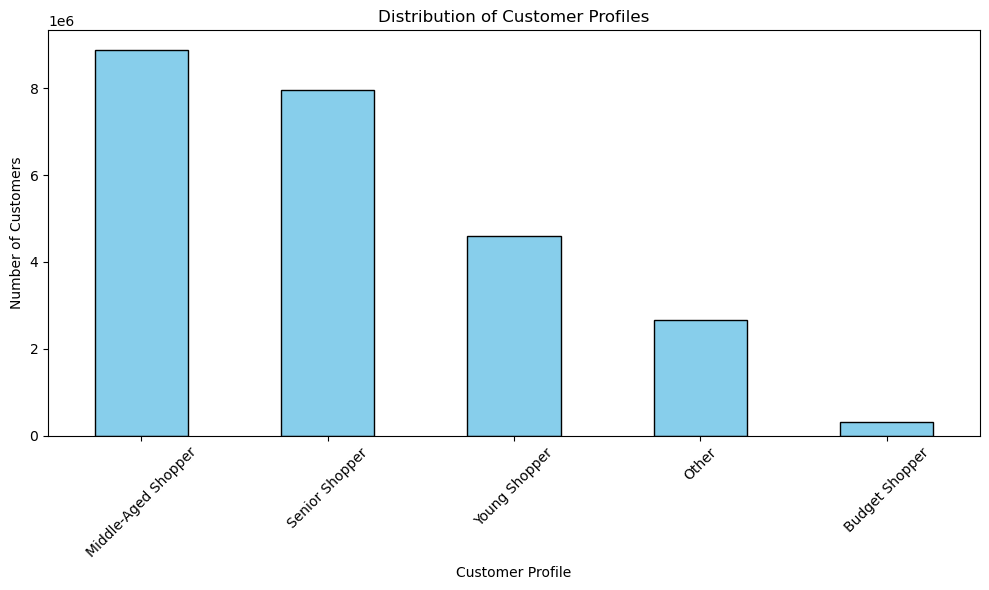

In [169]:
# Plot the distribution of customer profiles
bar2 = df_high_activity['customer_profile'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Profiles')
plt.xlabel('Customer Profile')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [170]:
# Save the chart as a PNG file
bar2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customer_profile.png'))

### Step 7:

In [171]:
# Aggregate usage frequency and expenditure by customer profile
profile_aggregates = df_high_activity.groupby('customer_profile').agg({'order_number': ['max', 'mean', 'min'],
'prices': ['max', 'mean', 'min']})

profile_aggregates.columns = ['_'.join(col).strip() for col in profile_aggregates.columns]
print(profile_aggregates)

                     order_number_max  order_number_mean  order_number_min  \
customer_profile                                                             
Budget Shopper                     99          21.548856                 5   
Middle-Aged Shopper                99          21.894225                 5   
Other                              99          22.270511                 5   
Senior Shopper                     99          21.951108                 5   
Young Shopper                      99          21.897733                 5   

                     prices_max  prices_mean  prices_min  
customer_profile                                          
Budget Shopper             25.0     6.715519         1.0  
Middle-Aged Shopper     99999.0    11.691897         1.0  
Other                   99999.0    12.769618         1.0  
Senior Shopper          99999.0    11.664735         1.0  
Young Shopper           99999.0    12.182256         1.0  


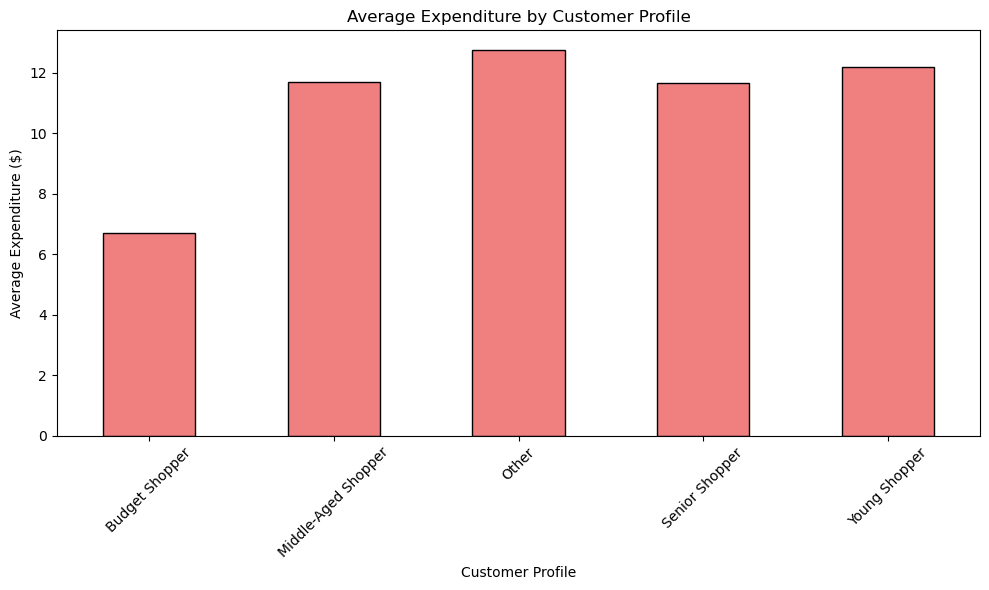

In [172]:
# Plot average expenditure by customer profile
plt.figure(figsize=(10, 6))
bar3 = profile_aggregates['prices_mean'].plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Average Expenditure by Customer Profile')
plt.xlabel('Customer Profile')
plt.ylabel('Average Expenditure ($)')
plt.xticks(rotation=45)
plt.tight_layout()

In [173]:
# Save the chart as a PNG file
bar3.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'avg_expenditure_profile.png'))

### Step 8:

In [174]:
# Crosstab for customer profiles and regions
profile_region_ct = pd.crosstab(df_high_activity['customer_profile'], df_high_activity['Region'], normalize='index') * 100
print(profile_region_ct)

Region                 Midwest  Northeast     Other      South       West
customer_profile                                                         
Budget Shopper       22.428208  17.378051  1.364735  34.763116  24.065890
Middle-Aged Shopper  23.470717  17.792954  1.849001  31.290848  25.596480
Other                24.073123  16.494071  1.848081  31.109524  26.475202
Senior Shopper       23.192567  17.943598  1.908730  31.336582  25.618523
Young Shopper        23.271710  17.681700  1.964943  31.721536  25.360110


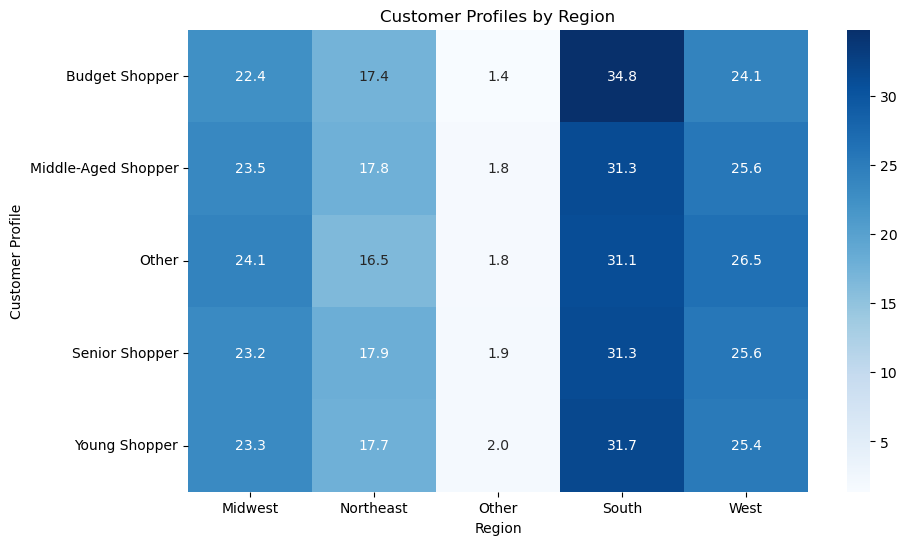

In [175]:
# Heatmap for profiles by region
plt.figure(figsize=(10, 6))
hm = sns.heatmap(profile_region_ct, annot=True, cmap='Blues', fmt=".1f")
plt.title('Customer Profiles by Region')
plt.xlabel('Region')
plt.ylabel('Customer Profile')
plt.show()

In [176]:
# Save the chart as a PNG file
hm.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customer_profile_by_region.png'))

In [177]:
# Crosstab for customer profiles and departments
profile_department_ct = pd.crosstab(df_high_activity['customer_profile'], df_high_activity['department_id'], normalize='index') * 100
print(profile_department_ct)

department_id              1         2         3          4         5   \
customer_profile                                                         
Budget Shopper       5.969121  0.146996  3.063639  25.181274  0.464265   
Middle-Aged Shopper  6.644207  0.107249  3.608201  29.592393  0.432932   
Other                6.698686  0.112308  3.723683  30.315604  0.496657   
Senior Shopper       6.720034  0.109577  3.618310  29.610713  0.425531   
Young Shopper        6.645702  0.118948  3.613238  29.490770  0.456314   

department_id              6          7         8         9         10  ...  \
customer_profile                                                        ...   
Budget Shopper       0.616682  11.469513  0.261468  1.828362  0.137749  ...   
Middle-Aged Shopper  0.812668   8.318071  0.288168  2.605773  0.112626  ...   
Other                0.841308   8.017086  0.295227  2.631822  0.105974  ...   
Senior Shopper       0.799073   8.404227  0.299629  2.586217  0.113115  ...   
Young S

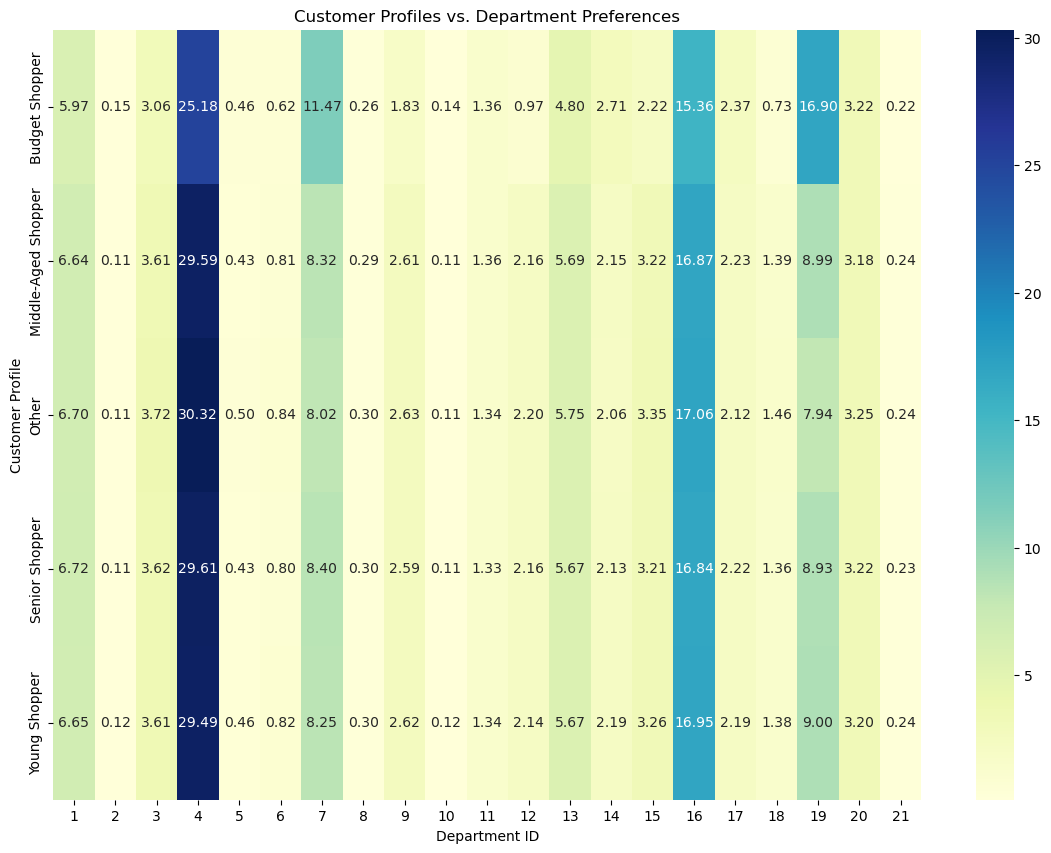

In [178]:
# Heatmap for profiles by department
plt.figure(figsize=(14, 10))
hm2 = sns.heatmap(profile_department_ct, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Customer Profiles vs. Department Preferences")
plt.xlabel("Department ID")
plt.ylabel("Customer Profile")
plt.show()

In [179]:
# Save the chart as a PNG file
hm2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customer_profile_department_preferences.png'))

###### The South consistently has the largest share of all profiles, which might reflect:
######    - A higher population or customer base in the South.
######    - Broader regional adoption of Instacart.
###### The West has the second-highest percentages across all profiles, showing significant usage.
###### The Northeast and Midwest have similar distributions but slightly less representation.
###### The Other category is negligible, with 1-2% representation.

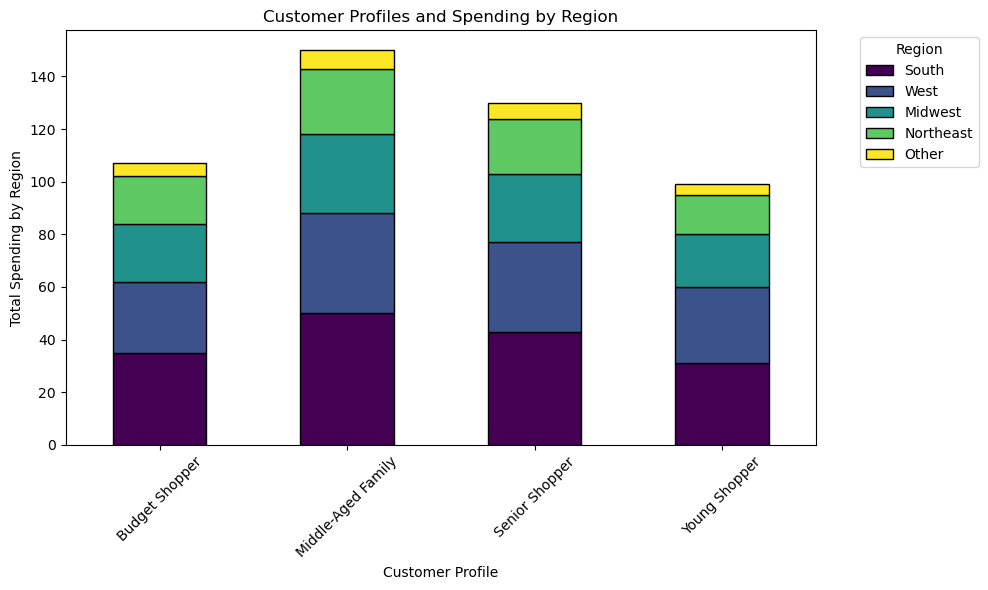

In [180]:
data = {'customer_profile': ['Budget Shopper', 'Middle-Aged Family', 'Senior Shopper', 'Young Shopper'],
'South': [35, 50, 43, 31],'West': [27, 38, 34, 29],'Midwest': [22, 30, 26, 20],'Northeast': [18, 25, 21, 15],
'Other': [5, 7, 6, 4]}
df_merged = pd.DataFrame(data)
# Plot stacked bar chart
bar4 = df_merged.set_index('customer_profile').plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title('Customer Profiles and Spending by Region')
plt.xlabel('Customer Profile')
plt.ylabel('Total Spending by Region')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [181]:
# Save the chart as a PNG file
bar4.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customer_profile_spending_region.png'))

In [184]:
orders_products_all = df_high_activity
orders_products_all.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_all.pkl'))

In [189]:
print(orders_products_all.info())
print(orders_products_all.head())

<class 'pandas.core.frame.DataFrame'>
Index: 24414877 entries, 16 to 30328762
Data columns (total 32 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   order_id                       int64   
 1   user_id                        object  
 2   order_number                   int64   
 3   orders_day_of_week             int32   
 4   order_hour_of_day              int32   
 5   days_since_prior_order         float64 
 6   product_id                     int64   
 7   add_to_cart_order              int64   
 8   reordered                      int64   
 9   product_name                   category
 10  aisle_id                       int64   
 11  department_id                  int64   
 12  prices                         float64 
 13  busiest_day                    category
 14  day_summary                    category
 15  busiest_period_of_day          category
 16  loyalty_flag                   category
 17  spending_flag                